In [4]:
!python multi_level_gae_v2.py

  0% 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100% 3000/3000 [01:07<00:00, 44.22it/s]
tcmalloc: large alloc 3110084608 bytes == 0x563591dee000 @  0x7fa61d2061e7 0x7fa5c0f0946e 0x7fa5c0f59c7b 0x7fa5c0f5a35f 0x7fa5c0ffc103 0x563519fc7010 0x563519fc6da0 0x56351a03abb3 0x56351a035c35 0x563519fc873a 0x56351a03793b 0x56351a035c35 0x563519fc873a 0x56351a03793b 0x56351a035c35 0x563519fc873a 0x56351a03af40 0x56351a035c35 0x56351a035933 0x56351a0ff402 0x56351a0ff77d 0x56351a0ff6

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install pymetis

In [6]:
import torch
from torch_geometric.datasets import Planetoid , KarateClub
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges 
from torch_geometric.utils import to_networkx,from_networkx
import matplotlib.pyplot as plt
import torch_geometric

dataset = Planetoid("\..", "Pubmed", transform=T.NormalizeFeatures())
#NX = to_networkx(dataset.data)
#dataset = KarateClub(transform = None)
#dataset.data
Graph = to_networkx(dataset[0])

In [7]:
import numpy as np
import pymetis
import timeit
from scipy.sparse import coo_matrix
import networkx as nx


def generate_adjlist_with_all_edges(G):
     for s, nbrs in G.adjacency():
        line = []
        line.append(s)
        for t, data in nbrs.items():
                line.append(t)
        yield line
Graph_list = []
for line in generate_adjlist_with_all_edges(Graph):
    Graph_list.append(np.array(line))

def generate_adjlist(graph):
  adjc_list = []
  for line in generate_adjlist_with_all_edges(graph):
    adjc_list.append(np.array(line))
  return adjc_list



def Metis_coarse(graph,n,percentage):     # what if graph have label vector, metis does not use this information to cluster, only pure graph structure 



  for k in range(n):

    size = graph.number_of_nodes() 
    coarse_size = int(np.floor(percentage * size))
  
    l = generate_adjlist(graph)
    n_cuts,groups = pymetis.part_graph(coarse_size, adjacency=l)

    
    x_coo = np.zeros((size,))
    y_coo = np.zeros((size,))
    data_coo = np.ones(size,)
    for j in range(size):
      x_coo[j] = j
      y_coo[j] = groups[j]


    sP = coo_matrix((data_coo,(x_coo,y_coo)),shape=(size,coarse_size))

    
    
    A = nx.to_scipy_sparse_matrix(graph)
  
    coarse = sP.T @ A @ sP 
    coarse.data = np.ones(coarse.nnz,)
    graph = nx.from_scipy_sparse_matrix(coarse)

  return graph,groups,sP


#if __name__ == "__main__":

c,partition,P = Metis_coarse(Graph,n=1,percentage=0.025)

  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 3000/3000 [01:16<00:00, 39.12it/s]


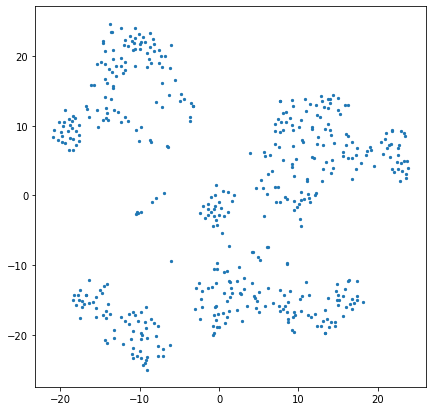

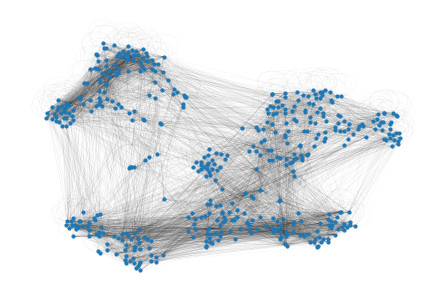

In [8]:
import torch
from torch_geometric.datasets import Planetoid , KarateClub
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges 
from torch_geometric.utils import to_networkx,from_networkx
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.nn import GAE
from tqdm import tqdm 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

coarsed_data = train_test_split_edges(from_networkx(c)) #from_scipy_sparse_matrix()


class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) 
        self.conv2 = GCNConv(2 * out_channels, 2*out_channels, cached=True)
        self.conv3 = GCNConv(2 * out_channels, out_channels, cached=True) 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x,edge_index).relu()
        return self.conv3(x, edge_index)

x = torch.eye(c.number_of_nodes())
train_pos_edge_index = from_networkx(c)['edge_index'].to(device)


out_channels = 20
num_features =c.number_of_nodes()#dataset.num_features
epochs = 3000

# model
model = GAE(GCNEncoder(num_features, out_channels))

model = model.to(device)
x = x.to(device)
train_pos_edge_index = train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


for epoch in tqdm(range(epochs)):
    loss = train()
    
    auc, ap = test(coarsed_data.test_pos_edge_index, coarsed_data.test_neg_edge_index)
    #print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Z = model.encode(x, train_pos_edge_index)
emb = Z.detach().cpu().numpy()



import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans




X_embedded = TSNE(n_components=2).fit_transform(emb)

kmeans = KMeans(n_clusters=7, random_state=0).fit(X_embedded)


plt.figure(figsize=(7,7))
plt.scatter(X_embedded[:,0],X_embedded[:,1],s = 5 )
plt.show()
nx.draw(c,X_embedded,node_size=10,width=0.02)

In [9]:
from scipy import sparse
import numpy as np





g = Graph
A = nx.to_numpy_matrix(g)

k_pos = X_embedded

coarse_size =emb.shape[0]

small_adj_list = generate_adjlist(g)                                            #generate fine graph adj list

                                                                                #set up parameters
#n_cuts,groups = pymetis.part_graph(coarse_size, adjacency=small_adj_list)
groups= partition                                                               

graph_size =  g.number_of_nodes()
num_groups = coarse_size


x_coo = np.zeros((graph_size,))
y_coo = np.zeros((graph_size,))
data_coo = np.ones((graph_size,))
for j in range(graph_size):
    x_coo[j] = j
    y_coo[j] = groups[j]


sP = coo_matrix((data_coo,(x_coo,y_coo)),shape=(graph_size,num_groups))
sP = sP.todense()
c_small = sP.T @ A @ sP                                                         #build coarse adj matrix in sparse
for i in range(num_groups):
  c_small[i,i]=0

c_small = nx.from_numpy_array(c_small)

c_small_emb = X_embedded                                                        #getting coarse graph embedding


c_small_aij = nx.to_numpy_array(c_small)

for i in range(num_groups):                                                     #remove self loop
  for j in range(num_groups):
    if c_small_aij[i,j]!= 0 :
      c_small_aij[i,j] =1




fine_emb = np.zeros((graph_size,2))                                             #init fine embedding with same as coarse group

for i in range(graph_size):
  fine_emb[i] = c_small_emb[groups[i]]



g_small = nx.from_numpy_array(c_small_aij)

g_small_adj_list = generate_adjlist(g_small)


def grad2(r_,small_adj_list,idx):
  grad = torch.zeros(1,1)

  

  
  grad = -1/(r_[idx])**2 + 1/(1-r_[idx])**2
  
  for j in small_adj_list[idx][1:]:
    
    grad -= 1/(torch.abs(r_[idx] - r_[j]) *(r_[idx]-r_[j]))
    
  return grad



c_small_tensor = torch.rand(num_groups,2)
for i in range(num_groups):
  c_small_tensor[i] = torch.from_numpy(c_small_emb[i])



d_sum = 0                                                                       #find average distance between coarse embedding
counter = 0
for i in range(coarse_size):
  for j in range(coarse_size):
    if i != j:
      d_sum += torch.norm(c_small_tensor[i] - c_small_tensor[j])
      counter += 1
d_sum = d_sum/counter

print(d_sum)
smallest = d_sum*0.1

                                                                                #init radious

r_ = torch.rand(graph_size,1)
r_ = r_ * smallest
'''

for iteration in tqdm(range(10)):
  for i in range(graph_size):
    gradient = grad2(r_,small_adj_list,idx=i)
    t = r_[i] - gradient*0.1
  
    if t * (0.5*smallest-t) > 0 :
      r_[i] = t
'''
                                                                                #init directional vector and normalized it
direction_vector = torch.rand(graph_size,2)
direction_vector = direction_vector / torch.norm(direction_vector)

for i in range(graph_size):
  direction_vector[i] = (direction_vector[i] / torch.norm(direction_vector[i]))
  direction_vector[i,0] = (torch.from_numpy(np.sign(np.random.default_rng().uniform(-1,1,1))))*direction_vector[i,0]
  direction_vector[i,1] = (torch.from_numpy(np.sign(np.random.default_rng().uniform(-1,1,1))))*direction_vector[i,1]


fine_emb2 = torch.zeros((graph_size,2))

                                                                                #move fine embedding away from center coarse embeddding
for i in range(graph_size):
  fine_emb2[i] = c_small_tensor[groups[i]] + r_[i]*direction_vector[i]



r_pos = fine_emb2.numpy()


tensor(23.4520)


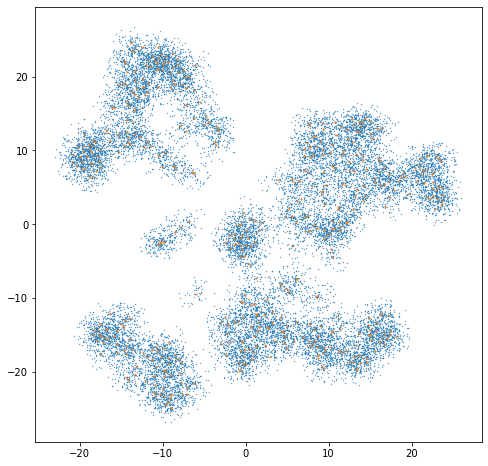

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(r_pos[:,0],r_pos[:,1],s=0.1)
plt.scatter(c_small_tensor[:,0],c_small_tensor[:,1],s=1)
plt.savefig('fine emb.png')